# Put-Call Parity

The put-call parity (PCP) establishes the relationship between call and put options that share the same underlying asset and expiration date. This relationship is especially relevant for European options. To illustrate it, we can create a portfolio composed of a long put option ($P$), a short call option ($C$), and a long position in a non-dividend-paying stock ($S$) of the underlying. Both options have the same strike price ($K$) and expiration date ($T$). The portfolio's structure before the expiration, at $t \leq T$, is described as follows:

$$
\begin{equation}
\begin{split}
\prod_{t}^{} &= S_{t} + max(K-S_{t},0) - max(S_{t}-K,0)\\
&= K e^{-r(t-T)}
\end{split}
\end{equation}
$$

In [19]:
import matplotlib.pyplot as plt
import QuantLib as ql

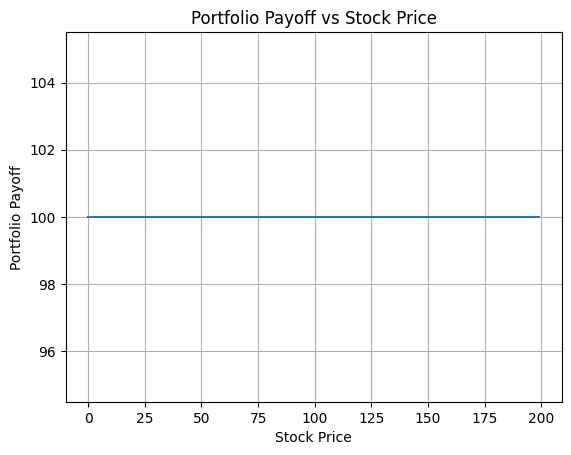

In [20]:
def porfolio_payoff(K):
  price_range = range(0,200)
  payoff = []
  for price in price_range:
    portfolio = price + max(K-price,0) - max(price-K,0)
    payoff.append(portfolio)
  return price_range,payoff

prices,payoff = porfolio_payoff(100)

plt.plot(prices, payoff)
plt.xlabel('Stock Price')
plt.ylabel('Portfolio Payoff')
plt.title('Portfolio Payoff vs Stock Price')
plt.grid(True)
plt.show()

From the above, we observe that the payoff equals the strike price $K$, providing a neat method to price a call or put option given the other. Additionally, the relationship holds regardless of the stock's price. This relationship relies on the absence of arbitrage, meaning that there is no initial investment $\prod_{0} = 0$ that guarantees a non-negative future payoff $\prod_{t} > 0$ with a non-zero probability. However, the put-call parity (PCP) may be violated due to market inefficiencies. While PCP does not hold for American options, a weaker relationship can still be established. Specifically, the portfolio with an American call option cannot be worth less than the portfolio with European options, all else being equal. This is also reflected in the plots from Lesson 2.


\begin{equation}
\begin{split}
S_{0} - K \leq C-P \leq S_{0} - K e^{-r(t-T)}
\end{split}
\end{equation}


The relationship above demonstrates that it is never optimal to exercise an American option early if the goal is to hold the stock until maturity. We can reach the same conclusion using an alternative approach. Consider two portfolios: Portfolio A, consisting of cash and an option, and Portfolio B, holding a single share of the underlying stock.


\begin{equation}
\begin{split}
\prod_{A(t)}{}&= K e^{-r(t-T)} + S_{t} -K\\
&= S_{t} -K (1-e^{-r(t-T)}) \leq S_{t}
\end{split}
\end{equation}



\begin{equation}
\begin{split}
\prod_{B(t)} &= S_{t}
\end{split}
\end{equation}


If the option is exercised before maturity, i.e at $t \leq T$, we have $\prod_{A(t)} \leq \prod_{B(t)}$. However, at maturity, we find that $\prod_{A(T)} = K + \max(S_{t} - K, 0) = \max(S_{t}, K)$. Which means that at maturity, $\prod_{A(T)} \geq \prod_{B(T)}$. If the investor wishes to exit their position, it is more advantageous to sell the option rather than exercising it, as the call option value $C > S - K$. Again, this result can be seen in plots Lesson 2 where the call price is more than the payoff.

In [21]:
def option_price(
    S0, K=100, days_to_maturity=30, r=0.4, sigma=0.5, call=True, is_European=True,engine="BS", steps=200, paths=10000
):


    today = ql.Date().todaysDate()
    maturity = today + days_to_maturity

    if call:
        option_type = ql.Option.Call
    else:
        option_type = ql.Option.Put


    payoff = ql.PlainVanillaPayoff(option_type, K)
    is_option_european = lambda european_exercise: ql.EuropeanExercise(maturity) if european_exercise==True else ql.AmericanExercise(today, maturity)
    option_exercise = is_option_european(is_European)


    option = ql.VanillaOption(payoff, option_exercise)

    spot = ql.SimpleQuote(S0)
    riskFreeTS = ql.YieldTermStructureHandle(
        ql.FlatForward(today, r, ql.Actual365Fixed())
    )
    volTS = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(today, ql.NullCalendar(), sigma, ql.Actual365Fixed())
    )


    process = ql.BlackScholesProcess(ql.QuoteHandle(spot), riskFreeTS, volTS)
    engine = ql.BinomialVanillaEngine(process, "crr", steps)
    option.setPricingEngine(engine)

    return option.NPV()

In [22]:
stock_prices = list(range(50, 200))
american_call = list(map(option_price, stock_prices))

In [23]:
strike = 100
call = lambda price: max(price-strike,0)
call_payoff = list(map(call, stock_prices))

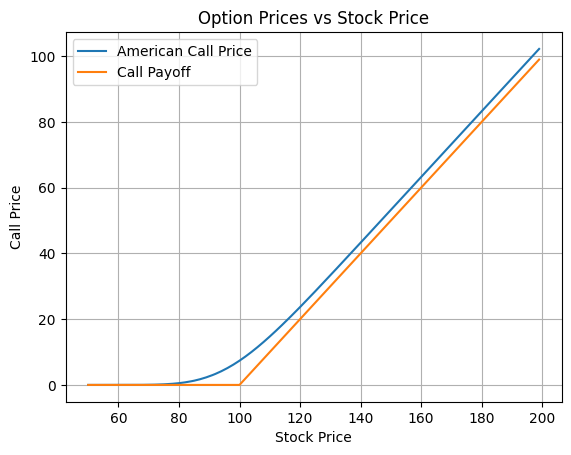

In [28]:
plt.plot(stock_prices, american_call, label='American Call Price')
plt.plot(stock_prices, call_payoff, label='Call Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Call Price')
plt.title('Option Prices vs Stock Price')
plt.legend()
plt.grid(True)
plt.show()

Finally, we observe that European put options can have negative time value when they are deep in the money. This occurs because the underlying asset's price may increase before the option's exercise date, reducing potential profits. In contrast, an American put option cannot have negative time value, as it can be exercised at any point up until the expiration date $t \leq T$.

In [33]:
american_put =[option_price(S0=price,is_European=False,call=False) for price in stock_prices]
european_put =[option_price(S0=price,is_European=True,call=False) for price in stock_prices]
put = lambda price: max(strike-price,0)
put_payoff = list(map(put, stock_prices))

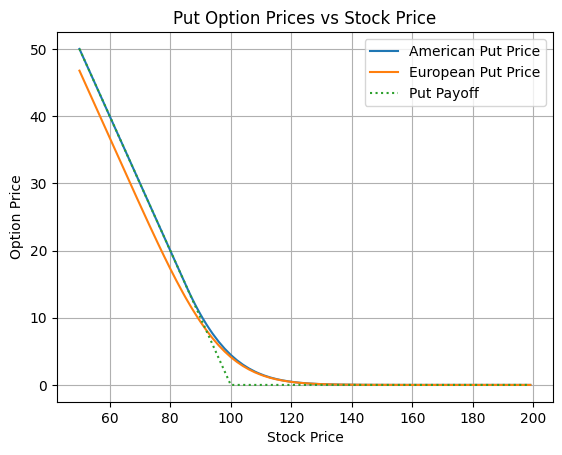

In [34]:
plt.plot(stock_prices, american_put, label='American Put Price')
plt.plot(stock_prices, european_put, label='European Put Price')
plt.plot(stock_prices, put_payoff, label='Put Payoff', linestyle=':')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Put Option Prices vs Stock Price')
plt.legend()
plt.grid(True)
plt.show()